In [3]:
import os

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import tensorflow as tf

import keras.backend as K
from keras.datasets import mnist
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.initializers import *
from keras.callbacks import *
from keras.utils.generic_utils import Progbar

In [2]:
RND = 777

RUN = 'B'
OUT_DIR = 'out/' + RUN
TENSORBOARD_DIR = '/tensorboard/wgans/' + RUN

# GPU # 
GPU = "0"

# latent vector size
Z_SIZE = 100

# number of iterations D is trained for per each G iteration
D_ITERS = 5

BATCH_SIZE = 100
ITERATIONS = 1000000

In [3]:
np.random.seed(RND)

In [4]:
if not os.path.isdir(OUT_DIR): os.makedirs(OUT_DIR)

In [5]:
# use specific GPU
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = GPU

In [6]:
K.set_image_dim_ordering('tf')

In [7]:
# basically return mean(y_pred),
# but with ability to inverse it for minimization (when y_true == -1)
def wasserstein(y_true, y_pred):
    return K.mean(y_true * y_pred)

In [8]:
def create_D():

    # weights are initlaized from normal distribution with below params
    weight_init = RandomNormal(mean=0., stddev=0.02)

    input_image = Input(shape=(28, 28, 1), name='input_image')

    x = Conv2D(
        32, (3, 3),
        padding='same',
        name='conv_1',
        kernel_initializer=weight_init)(input_image)
    x = LeakyReLU()(x)
    x = MaxPool2D(pool_size=2)(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        64, (3, 3),
        padding='same',
        name='conv_2',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        128, (3, 3),
        padding='same',
        name='conv_3',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=2)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    x = Conv2D(
        256, (3, 3),
        padding='same',
        name='coonv_4',
        kernel_initializer=weight_init)(x)
    x = MaxPool2D(pool_size=1)(x)
    x = LeakyReLU()(x)
    x = Dropout(0.3)(x)

    features = Flatten()(x)

    output_is_fake = Dense(
        1, activation='linear', name='output_is_fake')(features)

    output_class = Dense(
        10, activation='softmax', name='output_class')(features)

    return Model(
        inputs=[input_image], outputs=[output_is_fake, output_class], name='D')

In [9]:
def create_G(Z_SIZE=Z_SIZE):
    DICT_LEN = 10
    EMBEDDING_LEN = Z_SIZE

    # weights are initlaized from normal distribution with below params
    weight_init = RandomNormal(mean=0., stddev=0.02)

    # class#
    input_class = Input(shape=(1, ), dtype='int32', name='input_class')
    # encode class# to the same size as Z to use hadamard multiplication later on
    e = Embedding(
        DICT_LEN, EMBEDDING_LEN,
        embeddings_initializer='glorot_uniform')(input_class)
    embedded_class = Flatten(name='embedded_class')(e)

    # latent var
    input_z = Input(shape=(Z_SIZE, ), name='input_z')

    # hadamard product
    h = multiply([input_z, embedded_class], name='h')

    # cnn part
    x = Dense(1024)(h)
    x = LeakyReLU()(x)

    x = Dense(128 * 7 * 7)(x)
    x = LeakyReLU()(x)
    x = Reshape((7, 7, 128))(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(256, (5, 5), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)

    x = UpSampling2D(size=(2, 2))(x)
    x = Conv2D(128, (5, 5), padding='same', kernel_initializer=weight_init)(x)
    x = LeakyReLU()(x)

    x = Conv2D(
        1, (2, 2),
        padding='same',
        activation='tanh',
        name='output_generated_image',
        kernel_initializer=weight_init)(x)

    return Model(inputs=[input_z, input_class], outputs=x, name='G')

In [10]:
# with tf.device('/gpu:0'):

D = create_D()

D.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=[wasserstein, 'sparse_categorical_crossentropy'])

In [11]:
input_z = Input(shape=(Z_SIZE, ), name='input_z_')
input_class = Input(shape=(1, ),name='input_class_', dtype='int32')

In [12]:
# with tf.device('/gpu:0'):

G = create_G()

# create combined D(G) model
# D.trainable = False
output_is_fake, output_class = D(G(inputs=[input_z, input_class]))
DG = Model(inputs=[input_z, input_class], outputs=[output_is_fake, output_class])
DG.get_layer('D').trainable = False # freeze D in generator training faze

DG.compile(
    optimizer=RMSprop(lr=0.00005),
    loss=[wasserstein, 'sparse_categorical_crossentropy']
)

In [13]:
# load mnist data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# use all available 70k samples
X_train = np.concatenate((X_train, X_test))
y_train = np.concatenate((y_train, y_test))

# convert to -1..1 range, reshape to (sample_i, 28, 28, 1)
X_train = (X_train.astype(np.float32) - 127.5) / 127.5
X_train = np.expand_dims(X_train, axis=3)

In [14]:
# save 10x10 sample of generated images
def generate_samples(n=0, save=True):
    
    zz = np.random.normal(0., 1., (100, Z_SIZE))
    generated_classes = np.array(list(range(0, 10)) * 10)
    generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

    rr = []
    for c in range(10):
        rr.append(
            np.concatenate(generated_images[c * 10:(1 + c) * 10]).reshape(
                280, 28))
    img = np.hstack(rr)

    if save:
        plt.imsave(OUT_DIR + '/samples_%07d.png' % n, img, cmap=plt.cm.gray)
    
    return img

In [15]:
# write tensorboard summaries

sw = tf.summary.FileWriter(TENSORBOARD_DIR)


def update_tb_summary(step, write_sample_images=True):

    s = tf.Summary()

    # losses as is
    for names, vals in zip((('D_true_is_fake', 'D_true_class'),
                            ('D_fake_is_fake', 'D_fake_class'), ('DG_is_fake',
                                                                 'DG_class')),
                           (D_true_losses, D_fake_losses, DG_losses)):

        v = s.value.add()
        v.simple_value = vals[-1][1]
        v.tag = names[0]

        v = s.value.add()
        v.simple_value = vals[-1][2]
        v.tag = names[1]

    # D loss: -1*D_true_is_fake - D_fake_is_fake
    v = s.value.add()
    v.simple_value = -D_true_losses[-1][1] - D_fake_losses[-1][1]
    v.tag = 'D loss (-1*D_true_is_fake - D_fake_is_fake)'

    # generated image
    if write_sample_images:
        img = generate_samples(step, save=True)
        s.MergeFromString(tf.Session().run(
            tf.summary.image('samples_%07d' % step,
                             img.reshape([1, *img.shape, 1]))))

    sw.add_summary(s, step)
    sw.flush()

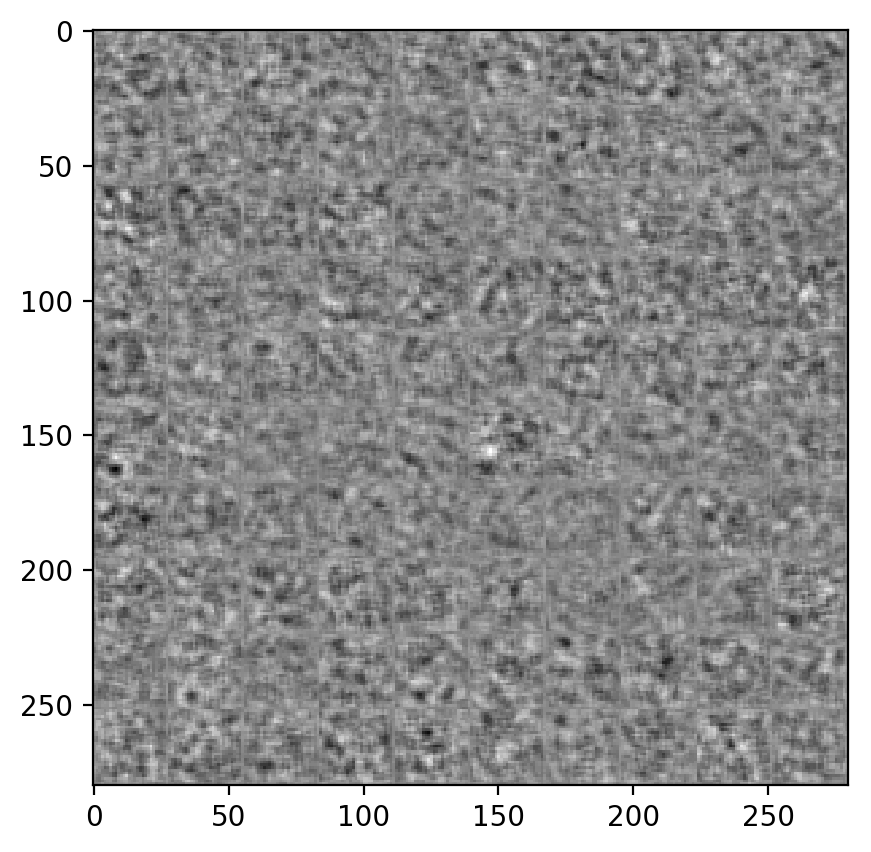

In [16]:
# try generating images
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(generate_samples(save=False), cmap=plt.cm.gray)

In [17]:
# fake = 1
# real = -1

progress_bar = Progbar(target=ITERATIONS)

DG_losses = []
D_true_losses = []
D_fake_losses = []

for it in range(ITERATIONS):

    if len(D_true_losses) > 0:
        progress_bar.update(
            it,
            values=[
                    ('D_real_is_fake', np.mean(D_true_losses[-5:], axis=0)[1]),
                    ('D_real_class', np.mean(D_true_losses[-5:], axis=0)[2]),
                    ('D_fake_is_fake', np.mean(D_fake_losses[-5:], axis=0)[1]),
                    ('D_fake_class', np.mean(D_fake_losses[-5:], axis=0)[2]),
                    ('D(G)_is_fake', np.mean(DG_losses[-5:],axis=0)[1]),
                    ('D(G)_class', np.mean(DG_losses[-5:],axis=0)[2])
            ]
        )
        
    else:
        progress_bar.update(it)

    # 1: train D on real+generated images

    if (it % 1000) < 25 or it % 500 == 0: # 25 times in 1000, every 500th
        d_iters = 100
    else:
        d_iters = D_ITERS

    for d_it in range(d_iters):

        # unfreeze D
        D.trainable = True
        for l in D.layers: l.trainable = True

        # clip D weights

        for l in D.layers:
            weights = l.get_weights()
            weights = [np.clip(w, -0.01, 0.01) for w in weights]
            l.set_weights(weights)

        # 1.1: maximize D output on reals === minimize -1*(D(real))

        # draw random samples from real images
        index = np.random.choice(len(X_train), BATCH_SIZE, replace=False)
        real_images = X_train[index]
        real_images_classes = y_train[index]

        D_loss = D.train_on_batch(real_images, [-np.ones(BATCH_SIZE), real_images_classes])
        D_true_losses.append(D_loss)

        # 1.2: minimize D output on fakes 

        zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE))
        generated_classes = np.random.randint(0, 10, BATCH_SIZE)
        generated_images = G.predict([zz, generated_classes.reshape(-1, 1)])

        D_loss = D.train_on_batch(generated_images, [np.ones(BATCH_SIZE), generated_classes])
        D_fake_losses.append(D_loss)

    # 2: train D(G) (D is frozen)
    # minimize D output while supplying it with fakes, telling it that they are reals (-1)

    # freeze D
    D.trainable = False
    for l in D.layers: l.trainable = False

    zz = np.random.normal(0., 1., (BATCH_SIZE, Z_SIZE)) 
    generated_classes = np.random.randint(0, 10, BATCH_SIZE)

    DG_loss = DG.train_on_batch(
        [zz, generated_classes.reshape((-1, 1))],
        [-np.ones(BATCH_SIZE), generated_classes])

    DG_losses.append(DG_loss)

    if it % 10 == 0:
        update_tb_summary(it, write_sample_images=(it % 10 == 0))

  32007/1000000 [..............................] - ETA: 497348s - D_real_is_fake: -1.6877 - D_real_class: 0.5539 - D_fake_is_fake: 1.3971 - D_fake_class: 0.3369 - D(G)_is_fake: -1.1529 - D(G)_class: 0.3303

KeyboardInterrupt: 